In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import KFold,GridSearchCV, HalvingGridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SequentialFeatureSelector, mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from itertools import product
import os

from PIL import Image  # "PIL" stands for the "pillow" library.  
# Pillow is a dependency of pytorch. Hence, if you installed pytorch correctly, you should not have anything else to install.

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

import warnings
warnings.filterwarnings('ignore')

# PART 1

### Import data

In [2]:
X_train = pd.read_csv("data/data_labeled/X_train.csv")
y_train = pd.read_csv("data/data_labeled/y_train.csv",header=None,names=['risk'])


X_test = pd.read_csv("data/data_labeled/X_test.csv")
y_test = pd.read_csv("data/data_labeled/y_test.csv",header=None,names=['risk'])

### Categorical data processing

In [3]:

#tranform to 0-4 because labels have a sense of order
consumption_map = {"Very low":0, "Low":1, "Moderate":2, "High":3, "Very high":4}
X_train["sarsaparilla"] = X_train["sarsaparilla"].replace(consumption_map);
X_train["smurfberry liquor"] = X_train["smurfberry liquor"].replace(consumption_map);
X_train["smurfin donuts"] = X_train["smurfin donuts"].replace(consumption_map);
X_test["sarsaparilla"] = X_test["sarsaparilla"].replace(consumption_map);
X_test["smurfberry liquor"] = X_test["smurfberry liquor"].replace(consumption_map);
X_test["smurfin donuts"] = X_test["smurfin donuts"].replace(consumption_map);


#tranform professions into one-hot encoding because they don't have a sense of order
def one_hot_encode(data,column="profession"):
    categories = np.unique(data[column])
    for i in range(len(categories)): #pour chaque profession
        new_col = []
        for entry in data[column]: #pour chaque patient
            if entry == categories[i]:
                new_col.append(1) #Si la profession == profession du patient
            else:
                new_col.append(0) #Si non
        data.insert(len(data.columns),categories[i],new_col)
    data.drop(column,axis=1,inplace=True)
        
try:
	one_hot_encode(X_train)
	one_hot_encode(X_test)
except:
	print("Already processed")
     
#Drop pictures
X_train.drop("img_filename",axis=1,inplace=True)
X_test.drop("img_filename",axis=1,inplace=True)

## Standardization

In [4]:
standardizer = StandardScaler()
X_train = pd.DataFrame(standardizer.fit_transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(standardizer.fit_transform(X_test),columns=X_train.columns)

## Visualise tranformed dataset

(array([-1.12307588, -0.32202318,  0.47902951,  1.28008221,  2.08113491]), array([272, 351, 170, 117,  90], dtype=int64))
(array([-1.97407681, -1.08685128, -0.19962574,  0.68759979,  1.57482532]), array([ 80, 164, 351, 261, 144], dtype=int64))
(array([-1.47513321, -0.75273693, -0.03034064,  0.69205564,  1.41445192]), array([187, 185, 219, 217, 192], dtype=int64))


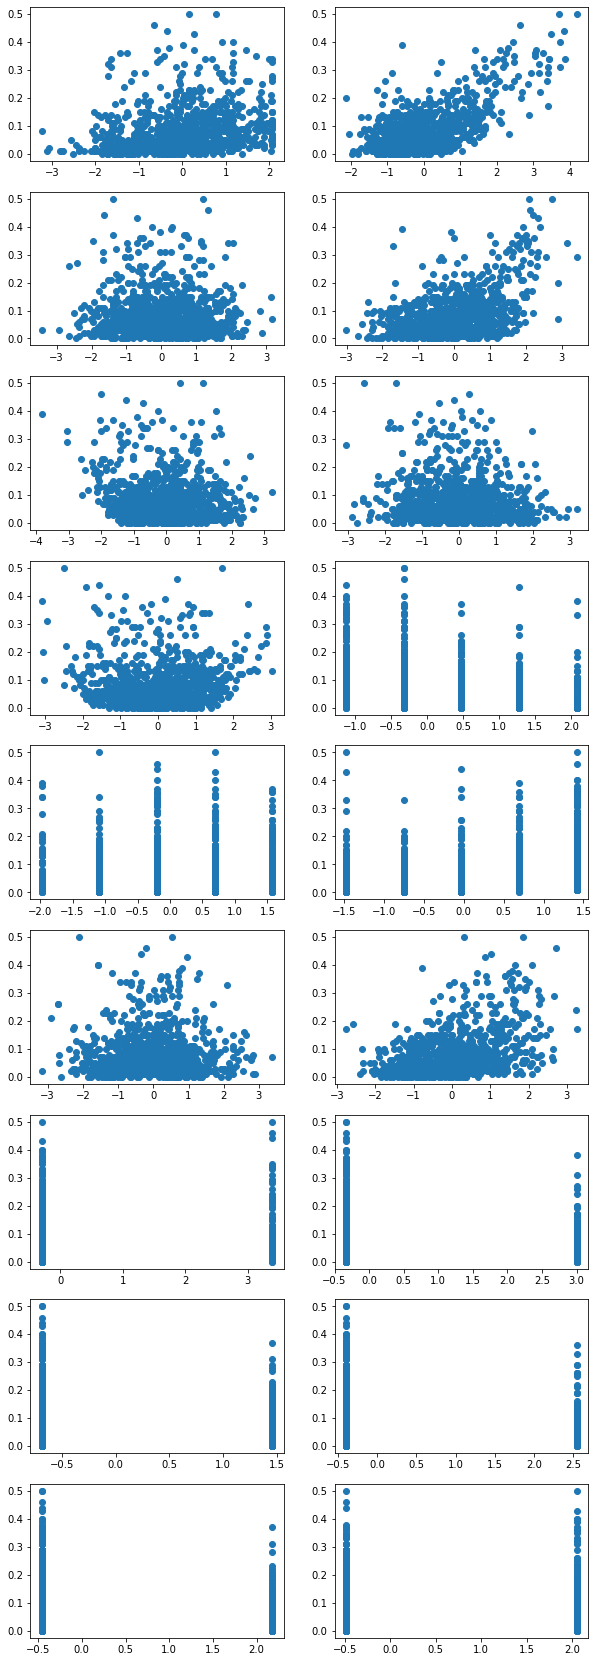

In [5]:
fig, axs = plt.subplots(9, 2, figsize=(10,30))

for index in range(18):
    axs[index//2,index%2].scatter(X_train[X_train.columns[index]],y_train)

		
print(np.unique(X_train["sarsaparilla"],return_counts=True))
print(np.unique(X_train["smurfberry liquor"],return_counts=True))
print(np.unique(X_train["smurfin donuts"],return_counts=True))

## Import X_unlabeled

In [6]:
#Import unlabeled data
X_unlabeled = pd.read_csv("data/data_unlabeled/X.csv")

#process categorical
X_unlabeled["sarsaparilla"] = X_unlabeled["sarsaparilla"].replace(consumption_map);
X_unlabeled["smurfberry liquor"] = X_unlabeled["smurfberry liquor"].replace(consumption_map);
X_unlabeled["smurfin donuts"] = X_unlabeled["smurfin donuts"].replace(consumption_map);

try:
	one_hot_encode(X_unlabeled)
except:
	print("Already processed")
     
#Drop pictures
X_unlabeled.drop("img_filename",axis=1,inplace=True)

#Normalize
X_unlabeled = pd.DataFrame(standardizer.transform(X_unlabeled),columns=X_train.columns)


### Evaluation

In [7]:
#To evaluate teh greedy search
def evaluate_feature_selection(X_train, X_test, y_train, y_test, model, selected_features):
    
    # train model
    model.fit(X_train[selected_features].values, y_train.values.ravel())
    
    # evaluate model
    y_pred = model.predict(X_test[selected_features].values) 
    rmse = np.sqrt(np.mean((y_pred-y_test.values.ravel() )**2))
    
    print(f"RMSE: {rmse:5.6f}")
    print(f"selected features: ")
    for i,feature in enumerate(selected_features):
        print(f"- {feature}")
    print("----------------------------------")
    

### Greedy search RMSE = 0.055596

In [8]:

model = LinearRegression() 
kf = KFold(n_splits=5, shuffle=True, random_state=42) #replaces the need to have a dedicated validation set
sfs = SequentialFeatureSelector(model,direction='backward',scoring='neg_root_mean_squared_error', cv=kf, n_jobs=-1)
sfs.fit(X_train,y_train)
selected_features = sfs.get_feature_names_out() # to modify

In [81]:
evaluate_feature_selection(X_train, X_test, y_train, y_test, model, selected_features)

RMSE: 0.055596
selected features: 
- age
- blood pressure
- cholesterol
- hemoglobin
- height
- potassium
- sarsaparilla
- weight
- food production
----------------------------------


## Output baseline predictions

In [82]:
# train model
model.fit(X_train[selected_features].values, y_train.values.ravel())
# make predictions on unlabeled data
y_pred = model.predict(X_unlabeled[selected_features].values)
pd.DataFrame(y_pred, columns=['y_pred']).to_csv("predictions/y_pred_baseline.csv",header=False, index=False)

### Without Greedy Search RMSE: 0.056053

In [83]:
model = LinearRegression()
selected_features = X_train.columns
evaluate_feature_selection(X_train, X_test, y_train, y_test, model, selected_features)

RMSE: 0.056053
selected features: 
- age
- blood pressure
- calcium
- cholesterol
- hemoglobin
- height
- potassium
- sarsaparilla
- smurfberry liquor
- smurfin donuts
- vitamin D
- weight
- administration and governance
- craftsmanship
- food production
- manufacturing
- resource extraction
- services
----------------------------------


# Part 2

## Mutual Information Feature Selection

In [9]:

mutual_info = pd.Series(mutual_info_regression(X_train,y_train,random_state=12))
mutual_info.index = X_train.columns
mi_features = mutual_info.sort_values(ascending=False)[mutual_info.sort_values(ascending=False)>0.01].index
mutual_info.sort_values(ascending=False)
X_train_mi = X_train[mi_features]
X_test_mi = X_test[mi_features]
mutual_info.sort_values(ascending=False)

blood pressure                   0.246548
cholesterol                      0.107657
weight                           0.085622
potassium                        0.059349
age                              0.058883
smurfin donuts                   0.054610
sarsaparilla                     0.042843
vitamin D                        0.039223
height                           0.018538
resource extraction              0.016866
hemoglobin                       0.015705
administration and governance    0.012315
food production                  0.003207
manufacturing                    0.000128
smurfberry liquor                0.000000
calcium                          0.000000
craftsmanship                    0.000000
services                         0.000000
dtype: float64

In [10]:
mi_matrix = []

for i in X_train.columns:
    row = []
    for j in X_train.columns:
        if j == i:
            row.append(0)
        else:row.append(float(mutual_info_regression(X_train[[i]],X_train[j])[0]))
    mi_matrix.append(row)

fig = px.imshow(
    mi_matrix,
    text_auto=True,
    color_continuous_scale=px.colors.sequential.Burg,
    x=X_train.columns,
    y=X_train.columns,
)
fig.update_xaxes(side="top")
fig.update_layout(
    height=800,  # Adjust these values as needed
    width=900
)

fig.show()

## Polynomial Regression 

#### Without feature selection RMSE = 0.043495

In [86]:
model = LinearRegression()


#Worse results from 3 onwards
for degree in [1, 2, 3]:
    print(f"=== Polynomial Degree {degree} ===")
    

    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = pd.DataFrame(poly.fit_transform(X_train), columns=poly.get_feature_names_out(X_train.columns))
    X_test_poly = pd.DataFrame(poly.transform(X_test), columns=poly.get_feature_names_out(X_train.columns))
    
    # Evaluate
    evaluate_feature_selection(X_train_poly, X_test_poly, y_train, y_test, model, X_train_poly.columns)

=== Polynomial Degree 1 ===
RMSE: 0.056053
selected features: 
- age
- blood pressure
- calcium
- cholesterol
- hemoglobin
- height
- potassium
- sarsaparilla
- smurfberry liquor
- smurfin donuts
- vitamin D
- weight
- administration and governance
- craftsmanship
- food production
- manufacturing
- resource extraction
- services
----------------------------------
=== Polynomial Degree 2 ===
RMSE: 0.043495
selected features: 
- age
- blood pressure
- calcium
- cholesterol
- hemoglobin
- height
- potassium
- sarsaparilla
- smurfberry liquor
- smurfin donuts
- vitamin D
- weight
- administration and governance
- craftsmanship
- food production
- manufacturing
- resource extraction
- services
- age^2
- age blood pressure
- age calcium
- age cholesterol
- age hemoglobin
- age height
- age potassium
- age sarsaparilla
- age smurfberry liquor
- age smurfin donuts
- age vitamin D
- age weight
- age administration and governance
- age craftsmanship
- age food production
- age manufacturing
- a

#### Greedy RMSE = 0.041886

In [34]:
model = LinearRegression()

#In reality, I did until 4 but that took a long time
for degree in [1, 2]:
    print(f"=== Polynomial Degree {degree} ===")
    
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = pd.DataFrame(poly.fit_transform(X_train), columns=poly.get_feature_names_out(X_train.columns))
    X_test_poly = pd.DataFrame(poly.transform(X_test), columns=poly.get_feature_names_out(X_train.columns))

    # Perform backward feature selection
    sfs = SequentialFeatureSelector(model, direction='forward',n_features_to_select=15, scoring='neg_root_mean_squared_error',n_jobs=-1,cv=kf)
    sfs.fit(X_train_poly, y_train)

    selected_features = sfs.get_feature_names_out()
    
    # Evaluate
    evaluate_feature_selection(X_train_poly, X_test_poly, y_train, y_test, model, selected_features)

=== Polynomial Degree 1 ===
RMSE: 0.056014
selected features: 
- age
- blood pressure
- calcium
- cholesterol
- hemoglobin
- height
- potassium
- sarsaparilla
- smurfberry liquor
- vitamin D
- weight
- administration and governance
- craftsmanship
- manufacturing
- services
----------------------------------
=== Polynomial Degree 2 ===
RMSE: 0.041886
selected features: 
- age
- blood pressure
- cholesterol
- hemoglobin
- height
- potassium
- sarsaparilla
- weight
- blood pressure^2
- cholesterol height
- cholesterol weight
- hemoglobin^2
- height weight
- potassium^2
- weight^2
----------------------------------


#### Mutual information RMSE: 0.041484

In [ ]:
model = LinearRegression()


#Worse results from 3 onwards
for degree in [1, 2, 3]:
    print(f"=== Polynomial Degree {degree} ===")
    

    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = pd.DataFrame(poly.fit_transform(X_train_mi), columns=poly.get_feature_names_out(X_train_mi.columns))
    X_test_poly = pd.DataFrame(poly.transform(X_test_mi), columns=poly.get_feature_names_out(X_train_mi.columns))
    
    # Evaluate
    evaluate_feature_selection(X_train_poly, X_test_poly, y_train, y_test, model, X_train_poly.columns)

=== Polynomial Degree 1 ===
RMSE: 0.056822
selected features: 
- blood pressure
- cholesterol
- weight
- potassium
- vitamin D
- age
- smurfin donuts
- sarsaparilla
- hemoglobin
----------------------------------
=== Polynomial Degree 2 ===
RMSE: 0.046629
selected features: 
- blood pressure
- blood pressure administration and governance
- blood pressure resource extraction
- blood pressure weight
- blood pressure smurfin donuts
- blood pressure^2
- blood pressure potassium
- blood pressure cholesterol
- smurfin donuts resource extraction
- weight administration and governance
- smurfin donuts administration and governance
- cholesterol
- cholesterol administration and governance
- blood pressure hemoglobin
- weight
- blood pressure sarsaparilla
- smurfin donuts sarsaparilla
- smurfin donuts
- cholesterol resource extraction
- sarsaparilla resource extraction
- smurfin donuts^2
- potassium administration and governance
- sarsaparilla administration and governance
- potassium smurfin do

### Output polynomial

In [36]:
# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = pd.DataFrame(poly.fit_transform(X_train), columns=poly.get_feature_names_out(X_train.columns))
X_unlabeled_poly = pd.DataFrame(poly.transform(X_unlabeled), columns=poly.get_feature_names_out(X_train.columns))

# Perform forward feature selection
sfs = SequentialFeatureSelector(model, direction='forward',scoring='neg_root_mean_squared_error',n_features_to_select=10,n_jobs=-1,cv=kf)
sfs.fit(X_train_poly, y_train)
selected_features = sfs.get_feature_names_out()

# train model
model.fit(X_train_poly[selected_features].values, y_train.values.ravel())
# make predictions on unlabeled data
y_pred = model.predict(X_unlabeled_poly[selected_features].values)

In [37]:
# Save to CSV
pd.DataFrame(y_pred, columns=['y_pred']).to_csv("predictions/y_pred_polynomial.csv",header=False, index=False)

## K-NN (With GridSearch)

In [38]:
# Définir la grille de paramètres à tester
param_grid = {
    'n_neighbors': list(range(1,11)), #best is 8 but we tested up to 30
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
}

### No feature selection RMSE: 0.060690

In [39]:
# Créer le modèle de base
knn = KNeighborsRegressor()

# Configurer GridSearchCV
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid, 
    cv=kf,  # notre KFold existant
    scoring='neg_root_mean_squared_error',  # RMSE
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Entraîner avec GridSearch
grid_search.fit(X_train, y_train)

# Afficher les résultats
print("\n" + "="*50)
print("MEILLEURS PARAMÈTRES TROUVÉS")
print(grid_search.best_params_)

# Récupérer le meilleur modèle
best_knn = grid_search.best_estimator_

# Évaluer le meilleur modèle
evaluate_feature_selection(X_train, X_test, y_train, y_test, best_knn, X_train.columns)


Fitting 5 folds for each of 40 candidates, totalling 200 fits

MEILLEURS PARAMÈTRES TROUVÉS
{'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'}
RMSE: 0.060690
selected features: 
- age
- blood pressure
- calcium
- cholesterol
- hemoglobin
- height
- potassium
- sarsaparilla
- smurfberry liquor
- smurfin donuts
- vitamin D
- weight
- administration and governance
- craftsmanship
- food production
- manufacturing
- resource extraction
- services
----------------------------------


#### Greedy RMSE = 0.052357

In [40]:
# Créer le modèle de base
knn = KNeighborsRegressor()

# Generate grid where SFS and final KNN share same params
greedy_param_grid = []
for k, w, m in product(param_grid["n_neighbors"], param_grid["weights"], param_grid["metric"]):
    greedy_param_grid.append({
        'sfs__estimator__n_neighbors': [k], 
        'sfs__estimator__weights': [w],
        'sfs__estimator__metric': [m],     
        'knn__n_neighbors': [k],             
        'knn__weights': [w],                  
        'knn__metric': [m]
    })

knn_pipeline = Pipeline([
    ('sfs', SequentialFeatureSelector(knn,direction='backward',scoring='neg_root_mean_squared_error', cv=kf, n_jobs=-1)),
    ('knn', knn)  # Same base estimator
])

# Configurer GridSearchCV
grid_search = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=greedy_param_grid, 
    cv=kf,  # notre KFold existant
    scoring='neg_root_mean_squared_error',  # RMSE
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Entraîner avec GridSearch
grid_search.fit(X_train, y_train)

# Afficher les résultats
print("\n" + "="*50)
print("MEILLEURS PARAMÈTRES TROUVÉS")
print(grid_search.best_params_)

# Récupérer le meilleur modèle
best_greedy_knn = grid_search.best_estimator_.named_steps['knn']
selected_features = grid_search.best_estimator_.named_steps['sfs'].get_feature_names_out()

# Évaluer le meilleur modèle
evaluate_feature_selection(X_train, X_test, y_train, y_test, best_greedy_knn, selected_features)

Fitting 5 folds for each of 40 candidates, totalling 200 fits

MEILLEURS PARAMÈTRES TROUVÉS
{'knn__metric': 'euclidean', 'knn__n_neighbors': 8, 'knn__weights': 'distance', 'sfs__estimator__metric': 'euclidean', 'sfs__estimator__n_neighbors': 8, 'sfs__estimator__weights': 'distance'}
RMSE: 0.052357
selected features: 
- age
- blood pressure
- cholesterol
- hemoglobin
- height
- potassium
- sarsaparilla
- smurfberry liquor
- weight
----------------------------------


### Mutual Information RMSE: 0.055618

In [41]:
# Créer le modèle de base
knn = KNeighborsRegressor()

# Configurer GridSearchCV
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid, 
    cv=kf,  # notre KFold existant
    scoring='neg_root_mean_squared_error',  # RMSE
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Entraîner avec GridSearch
grid_search.fit(X_train_mi, y_train)

# Afficher les résultats
print("\n" + "="*50)
print("MEILLEURS PARAMÈTRES TROUVÉS")
print(grid_search.best_params_)

# Récupérer le meilleur modèle
best_model = grid_search.best_estimator_

# Évaluer le meilleur modèle
evaluate_feature_selection(X_train_mi, X_test_mi, y_train, y_test, best_model, X_train_mi.columns)

Fitting 5 folds for each of 40 candidates, totalling 200 fits

MEILLEURS PARAMÈTRES TROUVÉS
{'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
RMSE: 0.055618
selected features: 
- blood pressure
- cholesterol
- weight
- potassium
- age
- smurfin donuts
- sarsaparilla
- vitamin D
- height
- resource extraction
- hemoglobin
- administration and governance
----------------------------------


## MLP (Neural Network)

In [ ]:
param_grid = {
    'hidden_layer_sizes': [(16,8),(32, 16), (64, 32)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.001, 0.01, 0.1],
    'learning_rate_init':[0.001, 0.01, 0.1],
    'max_iter': [200]
}

#### No feature selection RMSE: 0.042574

In [43]:
# Créer le modèle de base
mlp = MLPRegressor()

# Configurer GridSearchCV
grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid, 
    cv=kf,  # notre KFold existant
    scoring='neg_root_mean_squared_error',  # RMSE
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Entraîner avec GridSearch
grid_search.fit(X_train, y_train)

# Afficher les résultats
print("\n" + "="*50)
print("MEILLEURS PARAMÈTRES TROUVÉS")
print(grid_search.best_params_)

# Récupérer le meilleur modèle
best_mlp = grid_search.best_estimator_

# Évaluer le meilleur modèle
evaluate_feature_selection(X_train, X_test, y_train, y_test, best_mlp, X_train.columns)


Fitting 5 folds for each of 36 candidates, totalling 180 fits

MEILLEURS PARAMÈTRES TROUVÉS
{'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (32, 16), 'max_iter': 200, 'solver': 'lbfgs'}
RMSE: 0.042574
selected features: 
- age
- blood pressure
- calcium
- cholesterol
- hemoglobin
- height
- potassium
- sarsaparilla
- smurfberry liquor
- smurfin donuts
- vitamin D
- weight
- administration and governance
- craftsmanship
- food production
- manufacturing
- resource extraction
- services
----------------------------------


### Greedy MLP RMSE= 0.039636

In [44]:
# Créer le modèle de base
mlp = MLPRegressor()

# Generate grid where SFS and final KNN share same params
greedy_param_grid = []
for hls, activation, solver, a, max_i in product(param_grid["hidden_layer_sizes"], param_grid["activation"], param_grid["solver"],
                       param_grid["alpha"], param_grid["max_iter"]):
    greedy_param_grid.append({
        'sfs__estimator__hidden_layer_sizes': [hls], 
        'sfs__estimator__activation': [activation],
        'sfs__estimator__solver': [solver],
        'sfs__estimator__alpha': [a],
        'sfs__estimator__max_iter': [max_i],
        'mlp__hidden_layer_sizes': [hls], 
        'mlp__activation': [activation],
        'mlp__solver': [solver],
        'mlp__alpha': [a],
        'mlp__max_iter': [max_i]
    })

mlp_pipeline = Pipeline([
    ('sfs', SequentialFeatureSelector(mlp,direction='forward',scoring='neg_root_mean_squared_error', cv=kf, n_jobs=-1)),
    ('mlp', mlp)  # Same base estimator
])

# Configurer GridSearchCV
grid_search = HalvingGridSearchCV(
    estimator=mlp_pipeline,
    param_grid=greedy_param_grid, 
    cv=kf,  # notre KFold existant
    scoring='neg_root_mean_squared_error',  # RMSE
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Entraîner avec GridSearch
grid_search.fit(X_train, y_train)

# Afficher les résultats
print("\n" + "="*50)
print("MEILLEURS PARAMÈTRES TROUVÉS")
print(grid_search.best_params_)

# Récupérer le meilleur modèle
best_greedy_mlp = grid_search.best_estimator_.named_steps['mlp']
selected_features = grid_search.best_estimator_.named_steps['sfs'].get_feature_names_out()

# Évaluer le meilleur modèle
evaluate_feature_selection(X_train, X_test, y_train, y_test, best_greedy_mlp, selected_features)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 37
max_resources_: 1000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 36
n_resources: 37
Fitting 5 folds for each of 36 candidates, totalling 180 fits
----------
iter: 1
n_candidates: 12
n_resources: 111
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 2
n_candidates: 4
n_resources: 333
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 3
n_candidates: 2
n_resources: 999
Fitting 5 folds for each of 2 candidates, totalling 10 fits

MEILLEURS PARAMÈTRES TROUVÉS
{'mlp__activation': 'tanh', 'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': (16, 8), 'mlp__max_iter': 200, 'mlp__solver': 'lbfgs', 'sfs__estimator__activation': 'tanh', 'sfs__estimator__alpha': 0.1, 'sfs__estimator__hidden_layer_sizes': (16, 8), 'sfs__estimator__max_iter': 200, 'sfs__estimator__solver': 'lbfgs'}
RMSE: 0.039636
selected features: 
- age
- blood pressure
- 

### Mutual Information RMSE = 0.041113

In [45]:
# Créer le modèle de base
mlp = MLPRegressor()

# Configurer GridSearchCV
grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid, 
    cv=kf,  # notre KFold existant
    scoring='neg_root_mean_squared_error',  # RMSE
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Entraîner avec GridSearch
grid_search.fit(X_train_mi, y_train)

# Afficher les résultats
print("\n" + "="*50)
print("MEILLEURS PARAMÈTRES TROUVÉS")
print(grid_search.best_params_)

# Récupérer le meilleur modèle
best_mlp = grid_search.best_estimator_

# Évaluer le meilleur modèle
evaluate_feature_selection(X_train_mi, X_test_mi, y_train, y_test, best_mlp, X_train_mi.columns)

Fitting 5 folds for each of 36 candidates, totalling 180 fits

MEILLEURS PARAMÈTRES TROUVÉS
{'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (32, 16), 'max_iter': 200, 'solver': 'lbfgs'}
RMSE: 0.041113
selected features: 
- blood pressure
- cholesterol
- weight
- potassium
- age
- smurfin donuts
- sarsaparilla
- vitamin D
- height
- resource extraction
- hemoglobin
- administration and governance
----------------------------------


# Random Forest

In [46]:
param_grid = {
    'n_estimators': [250,300,350],
    'max_depth': [10,20],
    'min_samples_leaf': [1],
    'max_features': [None],  # sqrt≈4, 0.5=9 features
    'max_samples': [0.8]
}

### Without feature selection RMSE = 0.046568

In [47]:
# Créer le modèle de base
rfr = RandomForestRegressor(n_jobs=-1)

# Configurer GridSearchCV
grid_search = GridSearchCV(
    estimator=rfr,
    param_grid=param_grid, 
    cv=kf,  # notre KFold existant
    scoring='neg_root_mean_squared_error',  # RMSE
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Entraîner avec GridSearch
grid_search.fit(X_train, y_train)

# Afficher les résultats
print("\n" + "="*50)
print("MEILLEURS PARAMÈTRES TROUVÉS")
print(grid_search.best_params_)

# Récupérer le meilleur modèle
best_rfr = grid_search.best_estimator_

# Évaluer le meilleur modèle
evaluate_feature_selection(X_train, X_test, y_train, y_test, best_rfr, X_train.columns)

Fitting 5 folds for each of 6 candidates, totalling 30 fits

MEILLEURS PARAMÈTRES TROUVÉS
{'max_depth': 20, 'max_features': None, 'max_samples': 0.8, 'min_samples_leaf': 1, 'n_estimators': 300}
RMSE: 0.046568
selected features: 
- age
- blood pressure
- calcium
- cholesterol
- hemoglobin
- height
- potassium
- sarsaparilla
- smurfberry liquor
- smurfin donuts
- vitamin D
- weight
- administration and governance
- craftsmanship
- food production
- manufacturing
- resource extraction
- services
----------------------------------


### Greedy RMSE=0.046605

In [48]:

# Créer le modèle de base
rfr = RandomForestRegressor(n_jobs=-1)

# Generate grid where SFS and final KNN share same params
greedy_param_grid = []
for n_est, max_d, min_leaf, max_f, max_s in product(param_grid["n_estimators"], param_grid["max_depth"],
                       param_grid["min_samples_leaf"], param_grid["max_features"], param_grid["max_samples"]):
    greedy_param_grid.append({
        'sfs__estimator__n_estimators': [n_est], 
        'sfs__estimator__max_depth': [max_d],
        'sfs__estimator__min_samples_leaf': [min_leaf],
        'sfs__estimator__max_features': [max_f],
        'sfs__estimator__max_samples': [max_s],
        'rfr__n_estimators': [n_est], 
        'rfr__max_depth': [max_d],
        'rfr__min_samples_leaf': [min_leaf],
        'rfr__max_features': [max_f],
        'rfr__max_samples': [max_s]
    })

rfr_pipeline = Pipeline([
    ('sfs', SequentialFeatureSelector(rfr,direction='forward',scoring='neg_root_mean_squared_error', cv=kf, n_jobs=-1)),
    ('rfr', rfr)  # Same base estimator
])

# Configurer GridSearchCV
grid_search = HalvingGridSearchCV(
    estimator=rfr_pipeline,
    param_grid=greedy_param_grid, 
    cv=kf,  # notre KFold existant
    scoring='neg_root_mean_squared_error',  # RMSE
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Entraîner avec GridSearch
grid_search.fit(X_train, y_train)

# Afficher les résultats
print("\n" + "="*50)
print("MEILLEURS PARAMÈTRES TROUVÉS")
print(grid_search.best_params_)

# Récupérer le meilleur modèle
best_greedy_rfr = grid_search.best_estimator_.named_steps['rfr']
selected_features = grid_search.best_estimator_.named_steps['sfs'].get_feature_names_out()

# Évaluer le meilleur modèle
evaluate_feature_selection(X_train, X_test, y_train, y_test, best_greedy_rfr, selected_features)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 333
max_resources_: 1000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 333
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 1
n_candidates: 2
n_resources: 999
Fitting 5 folds for each of 2 candidates, totalling 10 fits

MEILLEURS PARAMÈTRES TROUVÉS
{'rfr__max_depth': 10, 'rfr__max_features': None, 'rfr__max_samples': 0.8, 'rfr__min_samples_leaf': 1, 'rfr__n_estimators': 250, 'sfs__estimator__max_depth': 10, 'sfs__estimator__max_features': None, 'sfs__estimator__max_samples': 0.8, 'sfs__estimator__min_samples_leaf': 1, 'sfs__estimator__n_estimators': 250}
RMSE: 0.046605
selected features: 
- age
- blood pressure
- cholesterol
- hemoglobin
- potassium
- sarsaparilla
- smurfin donuts
- weight
- resource extraction
----------------------------------


### Mutual Information RMSE = 0.046554

In [49]:
# Créer le modèle de base
rfr = RandomForestRegressor()

# Configurer GridSearchCV
grid_search = GridSearchCV(
    estimator=rfr,
    param_grid=param_grid, 
    cv=kf,  # notre KFold existant
    scoring='neg_root_mean_squared_error',  # RMSE
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Entraîner avec GridSearch
grid_search.fit(X_train_mi, y_train)

# Afficher les résultats
print("\n" + "="*50)
print("MEILLEURS PARAMÈTRES TROUVÉS")
print(grid_search.best_params_)

# Récupérer le meilleur modèle
best_rfr = grid_search.best_estimator_

# Évaluer le meilleur modèle
evaluate_feature_selection(X_train_mi, X_test_mi, y_train, y_test, best_rfr, X_train_mi.columns)

Fitting 5 folds for each of 6 candidates, totalling 30 fits

MEILLEURS PARAMÈTRES TROUVÉS
{'max_depth': 20, 'max_features': None, 'max_samples': 0.8, 'min_samples_leaf': 1, 'n_estimators': 250}
RMSE: 0.046554
selected features: 
- blood pressure
- cholesterol
- weight
- potassium
- age
- smurfin donuts
- sarsaparilla
- vitamin D
- height
- resource extraction
- hemoglobin
- administration and governance
----------------------------------


# Part 3 CNN

### Dataset

In [11]:
# Define a custom dataset class that inherits from the PyTorch Dataset class
class CustomDataset(Dataset):
    
    # Constructor for the dataset
    def __init__(self, images, images_directory, target=None, transform=None):
        # Initialize the dataset with the provided data and transformation options
        self.images = images #List of image filenames
        self.images_directory = images_directory # Directory where images are located
        self.target = target # Optional list of target labels
        
        # If no data transformation is provided, create a default transformation
        if transform is None:
            transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),  # Convert images to grayscale
                                            transforms.ToTensor(), # Convert the image to a PyTorch tensor
                                            transforms.Normalize(mean=[0.5], std=[0.5]) # Normalize the image data 
                                           ])
            
        self.transform = transform # Store the data transformation for later use

    # Define the length of the dataset (number of data samples)
    def __len__(self):
        return len(self.images)
    
    # Retrieve a specific data sample by its index
    def __getitem__(self, idx):
        # Construct the full path to the image file
        image_path = os.path.join(self.images_directory, self.images[idx])
        # Open the image using the PIL library
        image = Image.open(image_path)
        
        # Apply the data transformation if it exists
        if self.transform:
            image = self.transform(image)
        
        # If target labels are provided, return both the image and the corresponding label esle return only the image
        if self.target is not None:
            target = self.target[idx]
            return image, target
        else:
            return image

In [12]:
# Displays grid of sample images from dataset
def visualize_sample_images(dataset, gridsize=(3,8)):
    
    plt.close('all')
    
    data_loader = DataLoader(dataset, batch_size=100, shuffle=True)
    
    nrows, ncols = gridsize
    width, height = gridsize[::-1]
    fig, axes = plt.subplots(nrows, ncols, figsize=(width*1.5,height*1.5))

    for i, (images, labels) in enumerate(data_loader):
        if i == nrows:
            break

        for j in range(ncols):
            ax = axes[i, j]
            image = images[j].squeeze().numpy()
            label = labels[j].item()

            ax.imshow(image, cmap='gray')
            ax.set_title(f"Risk: {label}")
            ax.axis('off')
    plt.tight_layout()
    plt.show()

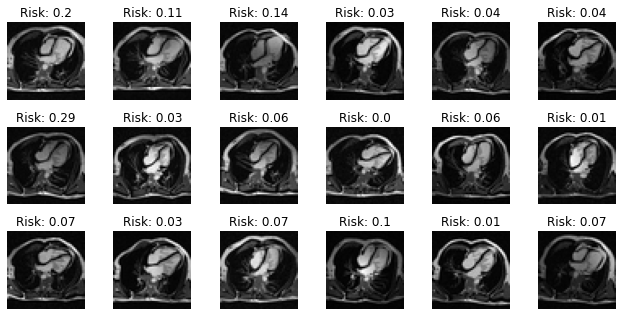

In [30]:
%matplotlib inline

# Retrieve image paths
images = pd.read_csv("data/data_labeled/X_train.csv")["img_filename"]

# Retrieve targets/labels
risk = pd.read_csv("data/data_labeled/y_train.csv", header=None, names=['risk'])

# Create image dataset
dataset = CustomDataset(images, "data/data_labeled/Img_train", target=risk.values)
  
# Display of grid of sample images from the dataset
visualize_sample_images(dataset, gridsize=(3,6))

## CNN Architecture

In [13]:
class SimpleCNN(nn.Module):
    
    # Constructor for the CNN 
    def __init__(self, n_features,use_padding=True, n_channels = 8):
        super(SimpleCNN, self).__init__()

        # Define the layers of the CNN
        # First convolutional layer with 1 input channel, 8 output channels, 3x3 kernel, and padding
        self.conv1 = nn.Conv2d(1, n_channels, kernel_size=3, stride=1, padding=int(use_padding))
        # First max-pooling layer with 2x2 kernel
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Second convolutional layer with 8 input channels, 8 output channels, 3x3 kernel, and padding
        self.conv2 = nn.Conv2d(n_channels, n_channels, kernel_size=3, stride=1, padding=int(use_padding))
        # Second max-pooling layer with 2x2 kernel
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Fully connected layer with input size 8*10*10 and output size n_features
        # Input size also changes if there is padding used
        self.fc1 = nn.Linear(n_channels*(10+int(use_padding*2))*(10+int(use_padding*2)), n_features)
        # Fully connected layer with input size n_features and output size 1
        self.fc2 = nn.Linear(n_features, 1) 
    
        
    # Define the forward pass of the model
    def forward(self, x):
        # Apply the two first convolutional layers with max-pooling and ReLU activation functions
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        # Reshape the data for the fully connected layers
        x = x.view(x.size(0),-1)
        # Pass the data through the first fully connected layer (and extract features)
        extracted_features = self.fc1(x)
        # Pass the extracted features through the second fully connected layer to get the final output
        out = self.fc2(extracted_features)
        # return output and extracted features
        return out, extracted_features


## Training and feature extraction

In [14]:
# Define a custom CNN model class (in this class, we define how to train the model)
class MyCNN(object):
    
    # Constructor for the custom CNN model
    def __init__(self, n_features=8, n_epochs=25, batch_size=20, learning_rate=0.0005, n_channels=8, pad=True):
        self.n_features = n_features
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.n_channels = n_channels
        self.pad = pad
    
    #Method to fit using cross-validation
    def fit_kf(self, images, y, data_dir, kf):
        
        # Store metrics for each fold
        fold_train_losses = []
        fold_val_losses = []
        
        # Iterate through each fold
        for fold, (train_idx, val_idx) in enumerate(kf.split(images)):
            print("Training Fold",fold+1)
            # Split data based on fold indices
            images_train = [images[i] for i in train_idx]
            y_train = y[train_idx]
            images_val = [images[i] for i in val_idx]
            y_val = y[val_idx]
        

            # Datasets
            train_dataset = CustomDataset(images_train, data_dir, y_train)
            val_dataset = CustomDataset(images_val, data_dir, y_val)

            # Data loaders
            train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)

            
            # Create an instance of the SimpleCNN model
            self.model = SimpleCNN(n_features=self.n_features,n_channels=self.n_channels, use_padding=self.pad)

            # Define loss function and optimizer
            criterion = nn.MSELoss(reduction='mean')
            optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
            
            # Training loop
            for epoch in range(self.n_epochs):

                # Set the model in training mode
                self.model.train()
                # Initialize running loss
                running_loss = 0
                # Iterate over batches of training data
                for i, data in enumerate(train_loader):
                    inputs, labels = data
                    
                    # Forward pass: Calculate model predictions and compute the loss
                    outputs, _ = self.model(inputs)
                    loss = criterion(outputs.squeeze(),labels.float())
                    
                    # Backpropagation: Zero the gradients, calculate gradients, and update the model's parameters
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    # Keep track of the running loss for this epoch
                    with torch.no_grad():
                        running_loss += loss.item()
                
                # Calculate the average training loss for this epoch
                train_loss = np.sqrt(running_loss/(i+1))

                # Model evaluation on the validation set
                # Set the model in evaluation mode
                self.model.eval()
                # Initialize running loss
                running_loss = 0
                # Iterate over batches of validation data
                for i, data in enumerate(val_loader):
                    inputs, labels = data
                    
                    # Forward pass: Calculate model predictions (no gradient calculation)
                    with torch.no_grad():
                        outputs, _ = self.model(inputs)
                        loss = criterion(outputs.squeeze(), labels.float())
                        running_loss += loss.item()
                
                # Calculate the average validation loss for this epoch
                val_loss = np.sqrt(running_loss/(i+1))
                
            # Store final losses for this fold
            fold_train_losses.append(train_loss)
            fold_val_losses.append(val_loss)
            print(f"Fold {fold + 1} Final - Train loss: {train_loss:.3f} | Val loss: {val_loss:.3f}\n")

        # Print average performance across all folds
        print(f"Average across all folds:")
        print(f"Train loss: {np.mean(fold_train_losses):.3f} (+/- {np.std(fold_train_losses):.3f})")
        print(f"Val loss: {np.mean(fold_val_losses):.3f} (+/- {np.std(fold_val_losses):.3f})")
        
        return np.mean(fold_train_losses)

    # Method to train the custom CNN model (at the end, once hyperparameters are chosen)
    def fit(self, images, y, data_dir):
        
        # Datasets
        train_dataset = CustomDataset(images, data_dir, y)

        # Data loaders
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        # Create an instance of the SimpleCNN model
        self.model = SimpleCNN(n_features=self.n_features,n_channels=self.n_channels, use_padding=self.pad)

        # Define loss function and optimizer
        criterion = nn.MSELoss(reduction='mean')
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        
        # Training loop
        for epoch in range(self.n_epochs):

            # Set the model in training mode
            self.model.train()
            # Initialize running loss
            running_loss = 0
            # Iterate over batches of training data
            for i, data in enumerate(train_loader):
                inputs, labels = data
                
                # Forward pass: Calculate model predictions and compute the loss
                outputs, _ = self.model(inputs)
                loss = criterion(outputs.squeeze(),labels.float())
                
                # Backpropagation: Zero the gradients, calculate gradients, and update the model's parameters
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # Keep track of the running loss for this epoch
                with torch.no_grad():
                    running_loss += loss.item()
            
            # Calculate the average training loss for this epoch
            train_loss = np.sqrt(running_loss/(i+1))

            
            # Print the training and validation loss every 5 epochs
            print("Epoch: {epoch:2d} | Train loss: {train:5.3f}".format(epoch=epoch+1,train=train_loss))

        

    # Method to make predictions with trained SimpleCNN model            
    def predict(self, images, data_dir):
        
        # Create a dataset from the input images and data directory
        dataset = CustomDataset(images, data_dir)
        # Create a data loader with a batch size equal to the number of input images
        loader = DataLoader(dataset, batch_size=len(images), shuffle=False)
        
        # Initialize an array to store predicted values
        y_pred = np.zeros(len(images))
        
        # Set the model to evaluation mode (to disable features like dropout if needed)
        self.model.eval()
        # Make predictions on the input images without gradient calculation
        with torch.no_grad():
            for inputs in loader:
                y_pred, _ = self.model(inputs)
        
        # Convert the predictions to a NumPy array and reshape it
        return y_pred.numpy().reshape(-1)
    
    
    # Method to extract features from input images with trained SimpleCNN model  
    def extract_features(self, images, data_dir):
        
        # Create a dataset from the input images and data directory
        dataset = CustomDataset(images, data_dir)
        # Create a data loader with a batch size equal to the number of input images
        loader = DataLoader(dataset, batch_size=len(images), shuffle=False)
    
        # Set the model to evaluation mode (to disable features like dropout)
        self.model.eval()
        # Extract features from the input images without gradient calculation
        with torch.no_grad():
            for inputs in loader:
                _, features = self.model(inputs)
        
        # Convert the extracted features to a NumPy array
        return features.numpy()
    

In [15]:
# Load data and retrieve paths to images
images_train = pd.read_csv("data/data_labeled/X_train.csv")["img_filename"].values
images_test = pd.read_csv("data/data_labeled/X_test.csv")["img_filename"].values
images_unlabeled = pd.read_csv("data/data_unlabeled/X.csv")["img_filename"].values

## Hyperparamter search

In [16]:
param_grid = {
    "lr": [0.0001],
    "batch_size": [50],
    "n_features": [8],
    "n_channels": [8,16],
    "epochs": [5,10],
    "use_padding": [True,False]
}

In [17]:
results = []
for n_features, batch_size, lr, n_channels, n_epochs, pad in product(
        param_grid["n_features"],
        param_grid["batch_size"],
        param_grid["lr"],
        param_grid["n_channels"],
        param_grid["epochs"],
        param_grid["use_padding"]
    ):

    # Create model with this configuration
    model = MyCNN(
        n_features=n_features,
        batch_size=batch_size,
        n_epochs=n_epochs,
        learning_rate=lr,
        n_channels=n_channels,
        pad=pad
    )
    
    avg_val_loss = model.fit_kf(images_train,y_train['risk'].values,'data/data_labeled/Img_train',kf)

    # Store results
    results.append({
        "n_features": n_features,
        "batch_size": batch_size,
        "learning_rate": lr,
        "n_epochs": n_epochs,
        "n_channels": n_channels,
        "padding?":pad,
        "avg_val_loss": avg_val_loss
    })

best_run = min(results, key=lambda x: x["avg_val_loss"])
print("\nBest configuration:")
print(best_run)

Training Fold 1
Fold 1 Final - Train loss: 0.083 | Val loss: 0.071

Training Fold 2
Fold 2 Final - Train loss: 0.078 | Val loss: 0.081

Training Fold 3
Fold 3 Final - Train loss: 0.081 | Val loss: 0.081

Training Fold 4
Fold 4 Final - Train loss: 0.078 | Val loss: 0.088

Training Fold 5
Fold 5 Final - Train loss: 0.082 | Val loss: 0.083

Average across all folds:
Train loss: 0.081 (+/- 0.002)
Val loss: 0.081 (+/- 0.005)
Training Fold 1
Fold 1 Final - Train loss: 0.087 | Val loss: 0.072

Training Fold 2
Fold 2 Final - Train loss: 0.080 | Val loss: 0.081

Training Fold 3
Fold 3 Final - Train loss: 0.083 | Val loss: 0.082

Training Fold 4
Fold 4 Final - Train loss: 0.079 | Val loss: 0.089

Training Fold 5
Fold 5 Final - Train loss: 0.080 | Val loss: 0.080

Average across all folds:
Train loss: 0.082 (+/- 0.003)
Val loss: 0.081 (+/- 0.005)
Training Fold 1
Fold 1 Final - Train loss: 0.079 | Val loss: 0.068

Training Fold 2
Fold 2 Final - Train loss: 0.077 | Val loss: 0.079

Training Fold 3


## Retrain final model with entire train set

In [36]:

# Create instance of cnn model
final_cnn = MyCNN(
        n_features=8,
        batch_size=50,
        n_epochs=20,
        learning_rate=0.0001,
        n_channels=64,
        pad=False
    )
# Fit cnn
final_cnn.fit(images_train, y_train['risk'].values, 'data/data_labeled/Img_train')

# Performance evaluation
y_pred = final_cnn.predict(images_test, 'data/data_labeled/Img_test')
rmse_cnn = np.sqrt(np.mean((y_pred-y_test['risk'].values)**2))
print("-----------------------------------------------")
print("RMSE on test set - MyCNN : {rmse:5.3f}".format(rmse=rmse_cnn))
print("-----------------------------------------------")

Epoch:  1 | Train loss: 0.151
Epoch:  2 | Train loss: 0.087
Epoch:  3 | Train loss: 0.083
Epoch:  4 | Train loss: 0.082
Epoch:  5 | Train loss: 0.079
Epoch:  6 | Train loss: 0.077
Epoch:  7 | Train loss: 0.075
Epoch:  8 | Train loss: 0.075
Epoch:  9 | Train loss: 0.071
Epoch: 10 | Train loss: 0.070
Epoch: 11 | Train loss: 0.067
Epoch: 12 | Train loss: 0.065
Epoch: 13 | Train loss: 0.065
Epoch: 14 | Train loss: 0.063
Epoch: 15 | Train loss: 0.062
Epoch: 16 | Train loss: 0.062
Epoch: 17 | Train loss: 0.062
Epoch: 18 | Train loss: 0.060
Epoch: 19 | Train loss: 0.060
Epoch: 20 | Train loss: 0.059
-----------------------------------------------
RMSE on test set - MyCNN : 0.062
-----------------------------------------------


## Extract features and add to part 2 model

In [38]:
train_img_features = pd.DataFrame(final_cnn.extract_features(images_train,'data/data_labeled/Img_train'))
test_img_features = pd.DataFrame(final_cnn.extract_features(images_test,"data/data_labeled/Img_test"))
unlabeled_img_features = pd.DataFrame(final_cnn.extract_features(images_unlabeled,"data/data_unlabeled/Img"))

X_train_with_features = pd.concat([X_train, train_img_features],axis=1)
X_train_with_features.columns = list(X_train.columns)+["img_feat_0","img_feat_1","img_feat_2","img_feat_3","img_feat_4","img_feat_5","img_feat_6","img_feat_7"]
X_test_with_features = pd.concat([X_test, test_img_features],axis=1)
X_test_with_features.columns = list(X_test.columns)+["img_feat_0","img_feat_1","img_feat_2","img_feat_3","img_feat_4","img_feat_5","img_feat_6","img_feat_7"]
X_unlabeled_with_features = pd.concat([X_unlabeled, unlabeled_img_features],axis=1)
X_unlabeled_with_features.columns = list(X_unlabeled.columns)+["img_feat_0","img_feat_1","img_feat_2","img_feat_3","img_feat_4","img_feat_5","img_feat_6","img_feat_7"]



In [39]:
param_grid = {
    'hidden_layer_sizes': [(16,8),(32, 16), (64, 32)],
    'activation': ['relu', 'tanh'],
    'solver': ['lbfgs'],
    'alpha': [0.001],
    'max_iter': [200]
}

## Greedy FINAL (RMSE: 0.031022)

In [40]:
# Créer le modèle de base
mlp = MLPRegressor()

# Generate grid where SFS and final KNN share same params
greedy_param_grid = []
for hls, activation, solver, a, max_i in product(param_grid["hidden_layer_sizes"], param_grid["activation"], param_grid["solver"],
                       param_grid["alpha"], param_grid["max_iter"]):
    greedy_param_grid.append({
        'sfs__estimator__hidden_layer_sizes': [hls], 
        'sfs__estimator__activation': [activation],
        'sfs__estimator__solver': [solver],
        'sfs__estimator__alpha': [a],
        'sfs__estimator__max_iter': [max_i],
        'mlp__hidden_layer_sizes': [hls], 
        'mlp__activation': [activation],
        'mlp__solver': [solver],
        'mlp__alpha': [a],
        'mlp__max_iter': [max_i]
    })

mlp_pipeline = Pipeline([
    ('sfs', SequentialFeatureSelector(mlp,direction='forward',scoring='neg_root_mean_squared_error', cv=kf, n_jobs=-1)),
    ('mlp', mlp)  # Same base estimator
])

# Configurer GridSearchCV
grid_search = HalvingGridSearchCV(
    estimator=mlp_pipeline,
    param_grid=greedy_param_grid, 
    cv=kf,  # notre KFold existant
    scoring='neg_root_mean_squared_error',  # RMSE
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Entraîner avec GridSearch
grid_search.fit(X_train_with_features, y_train)

# Afficher les résultats
print("\n" + "="*50)
print("MEILLEURS PARAMÈTRES TROUVÉS")
print(grid_search.best_params_)

# Récupérer le meilleur modèle
best_greedy_mlp = grid_search.best_estimator_.named_steps['mlp']
selected_features = grid_search.best_estimator_.named_steps['sfs'].get_feature_names_out()

# Évaluer le meilleur modèle
evaluate_feature_selection(X_train_with_features, X_test_with_features, y_train, y_test, best_greedy_mlp, selected_features)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 333
max_resources_: 1000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 333
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 1
n_candidates: 2
n_resources: 999
Fitting 5 folds for each of 2 candidates, totalling 10 fits

MEILLEURS PARAMÈTRES TROUVÉS
{'mlp__activation': 'tanh', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (16, 8), 'mlp__max_iter': 200, 'mlp__solver': 'lbfgs', 'sfs__estimator__activation': 'tanh', 'sfs__estimator__alpha': 0.001, 'sfs__estimator__hidden_layer_sizes': (16, 8), 'sfs__estimator__max_iter': 200, 'sfs__estimator__solver': 'lbfgs'}
RMSE: 0.031022
selected features: 
- age
- blood pressure
- cholesterol
- hemoglobin
- potassium
- sarsaparilla
- img_feat_0
- img_feat_2
- img_feat_3
- img_feat_4
- img_feat_5
- img_feat_6
- img_feat_7
----------------------------------


# FINAL PREDICTION!!!!

In [46]:
selected_features=["age",
"blood pressure",
"cholesterol",
"hemoglobin",
"potassium",
"sarsaparilla",
"img_feat_0",
"img_feat_1",
"img_feat_2",
"img_feat_3",
"img_feat_4",
"img_feat_5",
"img_feat_6",
"img_feat_7",]

In [47]:
X_all_labeled = pd.concat([X_train_with_features,X_test_with_features])
y_all_labeled = pd.concat([y_train,y_test])

In [48]:
mlp = MLPRegressor(activation='tanh',alpha=0.01,hidden_layer_sizes=(16,8),max_iter=200,solver='lbfgs')


# train model
mlp.fit(X_all_labeled[selected_features].values, y_all_labeled.values.ravel())

# make predictions on unlabeled data
y_pred = mlp.predict(X_unlabeled_with_features[selected_features].values)
pd.DataFrame(y_pred, columns=['y_pred']).to_csv("predictions/y_pred_best_part3.csv",header=False, index=False)